# Calidad de resultados segun k y alpha

## Pre - Experimentacion

In [21]:
# make cpp libraries
!cd ../../ && mkdir build
!cd ../../build/ && rm -rf *
!cd ../../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/lucas/.virtualenvs/metnum_tp2/bin/python (found version "3.8.10") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/lucas/Desktop/MetNum/TP/TP2/metnum_tp2
-- Configuring d

In [22]:
# verifico version de python e importo metnum
!pwd
!python --version

import sys
import os

p = os.path.abspath('../')
sys.path.insert(1, p)

import metnum

/home/lucas/Desktop/MetNum/TP/TP2/metnum_tp2/notebooks/calidad_k_alpha
Python 3.8.10


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time

In [24]:
#funcion general del modelo
def predict(X_train, y_train, X_val, alpha, k, con_pca):
    
    clf = metnum.KNNClassifier(k)
    
    if con_pca:
        
        pca = metnum.PCA(alpha)
        pca.fit(X_train)
        
        X_train = pca.transform(X_train)
        X_val = pca.transform(X_val)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    return y_pred

In [25]:
# Extraigo data set MNIST
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../../data/train.csv")

df_train = df_train.sample(frac = 1) # shuffle df

#df_train = df_train[:5000]

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## KNN (sin PCA)

In [26]:
#Particiono los datos
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

In [27]:
k_list = [1,2,5,10,20,50,100]

acc_list = []
prec_list = []
rec_list = []

time_list = []

print("hey")

for k in k_list:
    
    print("k: " + str(k))
    
    start = time.time()
    y_pred = predict(X_train, y_train, X_val, 0,  k, False)
    end = time.time()
    
    time_list.append(end - start)
    
    y_pred = y_pred.reshape(len(y_pred), 1)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average = "macro")
    rec = recall_score(y_val, y_pred, average = "macro")
    
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    
print("enjoy your data")

hey
k: 1
k: 2
k: 5
k: 10
k: 20
k: 50
k: 100
enjoy your data


## KNN con PCA

In [28]:
k_list = [1,2,5,10,20,50,100]
alpha_list = [1,5,10,50,100]

acc_list_pca = []
prec_list_pca = []
rec_list_pca = []

time_list_pca = []

print("hey")

for k in k_list:
    
    for alpha in alpha_list:
        
        print("k: " + str(k) + " alpha: " + str(alpha))
    
        start = time.time()
        y_pred = predict(X_train, y_train, X_val, alpha,  k, True)
        end = time.time()
        
        y_pred = y_pred.reshape(len(y_pred), 1)
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average = "macro")
        rec = recall_score(y_val, y_pred, average = "macro")
        
        time_list_pca.append(end - start)
        
        acc_list_pca.append(acc)
        prec_list_pca.append(prec)
        rec_list_pca.append(rec)

print("enjoy your data")

hey
k: 1 alpha: 1
k: 1 alpha: 5
k: 1 alpha: 10
k: 1 alpha: 50
k: 1 alpha: 100
k: 2 alpha: 1
k: 2 alpha: 5
k: 2 alpha: 10
k: 2 alpha: 50
k: 2 alpha: 100
k: 5 alpha: 1
k: 5 alpha: 5
k: 5 alpha: 10
k: 5 alpha: 50
k: 5 alpha: 100
k: 10 alpha: 1
k: 10 alpha: 5
k: 10 alpha: 10
k: 10 alpha: 50
k: 10 alpha: 100
k: 20 alpha: 1
k: 20 alpha: 5
k: 20 alpha: 10
k: 20 alpha: 50
k: 20 alpha: 100
k: 50 alpha: 1
k: 50 alpha: 5
k: 50 alpha: 10
k: 50 alpha: 50
k: 50 alpha: 100
k: 100 alpha: 1
k: 100 alpha: 5
k: 100 alpha: 10
k: 100 alpha: 50
k: 100 alpha: 100
enjoy your data


## Data analisys

In [29]:
import json

In [30]:
# Guardar datos en archivo

data = {
    "k_list": k_list,
    "alpha_list": alpha_list,
    "acc_list": acc_list,
    "prec_list": prec_list,
    "rec_list": rec_list,
    "time_list": time_list,
    "acc_list_pca": acc_list_pca,
    "prec_list_pca": prec_list_pca,
    "rec_list_pca": rec_list_pca,
    "time_list_pca": time_list_pca
}

with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)

In [31]:
# Leer datos de archivo

with open('data.txt') as json_file:
    data = json.load(json_file)

In [32]:
#Asigno datos lectura de archivos

k_list = np.array(data["k_list"])
alpha_list = np.array(data["alpha_list"])
acc_list = np.array(data["acc_list"])
prec_list = np.array(data["prec_list"])
rec_list = np.array(data["rec_list"])
time_list = np.array(data["time_list"])
acc_list_pca = np.array(data["acc_list_pca"])
prec_list_pca = np.array(data["prec_list_pca"])
rec_list_pca = np.array(data["rec_list_pca"])
time_list_pca = np.array(data["time_list_pca"])

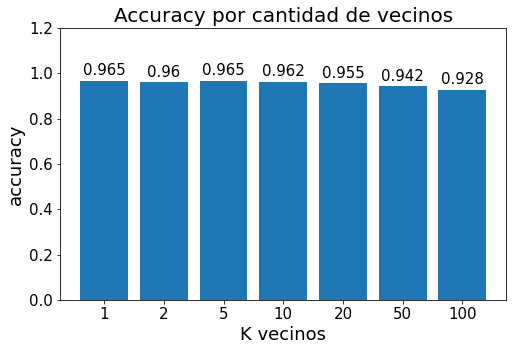

In [33]:
plt.figure(figsize = (8,5))

rec = plt.bar(list(map(lambda x: str(x), k_list)), list(map(lambda x: round(x,3),acc_list)))
plt.title("Accuracy por cantidad de vecinos", fontsize = 20)
plt.bar_label(rec, padding = 3, fontsize = 15)
plt.ylabel("accuracy", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,1.2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

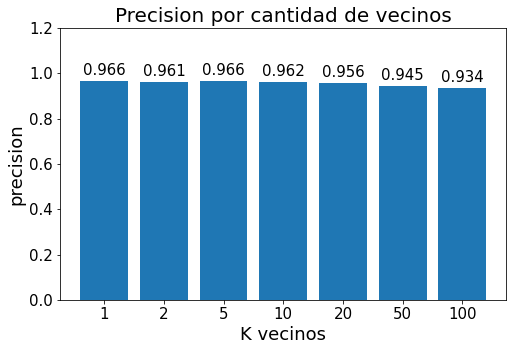

In [34]:
plt.figure(figsize = (8,5))

rec = plt.bar(list(map(lambda x: str(x), k_list)), list(map(lambda x: round(x,3),prec_list)))
plt.title("Precision por cantidad de vecinos", fontsize = 20)
plt.bar_label(rec, padding = 3, fontsize = 15)
plt.ylabel("precision", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,1.2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

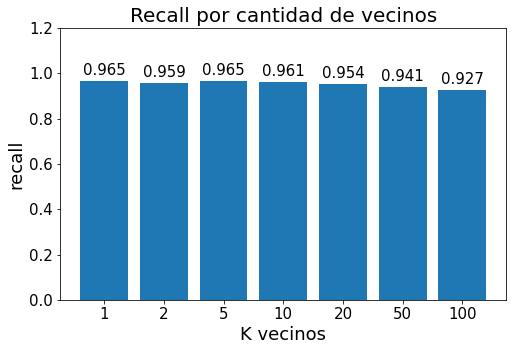

In [35]:
plt.figure(figsize = (8,5))

rec = plt.bar(list(map(lambda x: str(x), k_list)), list(map(lambda x: round(x,3),rec_list)))
plt.title("Recall por cantidad de vecinos", fontsize = 20)
plt.bar_label(rec, padding = 3, fontsize = 15)
plt.ylabel("recall", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,1.2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

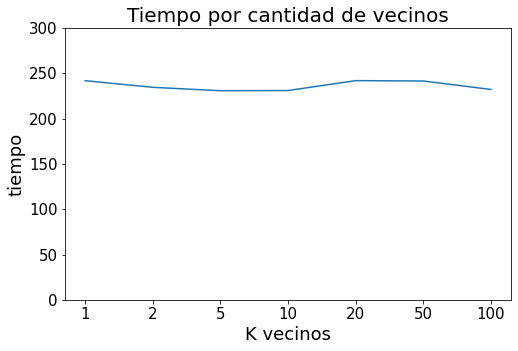

In [43]:
plt.figure(figsize = (8,5))

plt.plot(list(map(lambda x: str(x), k_list)), list(map(lambda x: round(x,3),time_list)))
plt.title("Tiempo por cantidad de vecinos", fontsize = 20)
plt.ylabel("tiempo", fontsize = 18)
plt.xlabel("K vecinos", fontsize = 18)
plt.ylim(0,300)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

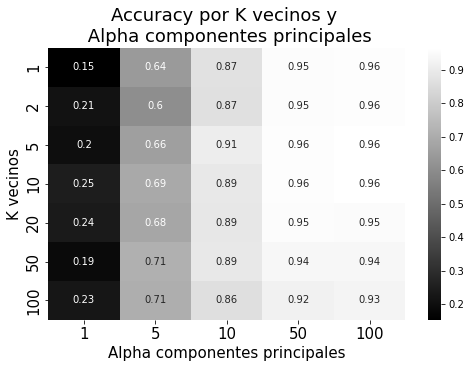

In [37]:
plt.figure(figsize = (8,5))

sns.heatmap(acc_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title("Accuracy por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

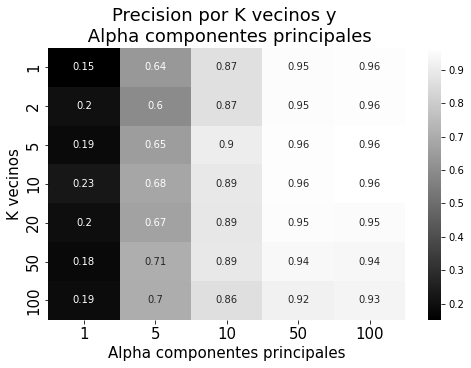

In [38]:
plt.figure(figsize = (8,5))

sns.heatmap(prec_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title("Precision por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

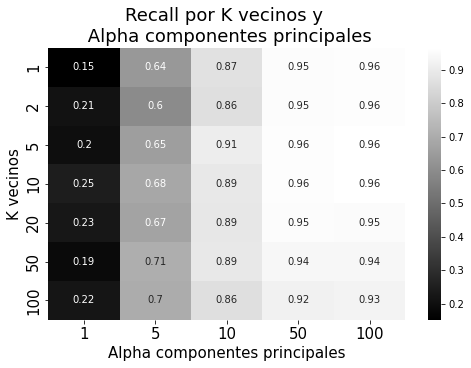

In [39]:
plt.figure(figsize = (8,5))

sns.heatmap(rec_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title("Recall por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

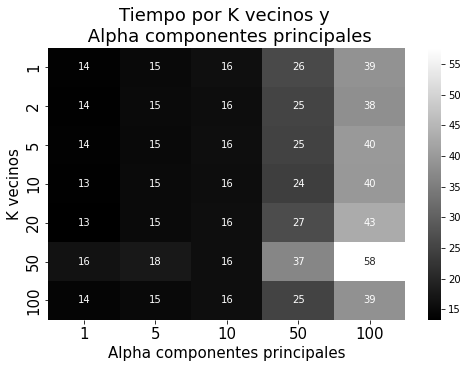

In [40]:
plt.figure(figsize = (8,5))

sns.heatmap(time_list_pca.reshape((len(k_list), len(alpha_list))), cmap = "gray", annot = True)
plt.yticks(ticks = np.arange(len(k_list))+0.5, labels = list(map(lambda x: str(x), k_list)))
plt.xticks(ticks = np.arange(len(alpha_list))+0.5, labels = list(map(lambda x: str(x), alpha_list)))
plt.title("Tiempo por K vecinos y \n Alpha componentes principales", fontsize = 18)
plt.ylabel("K vecinos", fontsize = 15)
plt.xlabel("Alpha componentes principales", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()